
Selección de rezagos (BIC):
  p        SSE          AIC          BIC  chosen
 1 346.517414 -2933.755641 -2881.012502   False
 2 333.286020 -2977.664390 -2885.398984    True
 3 331.995115 -2958.567784 -2826.810271   False
 4 330.631647 -2939.872311 -2768.652925   False
 5 329.379944 -2920.581750 -2709.930803   False
 6 326.766257 -2908.711268 -2658.659147   False

VAR lineal (p=2) — SSE=333.286, sigma2=0.1858, AIC=-2977.66, BIC=-2885.40

TVAR — umbral estimado c ≈ 0.013
TVAR — SSE=319.215, sigma2=0.1779, AIC=-3011.05, BIC=-2822.13

=== TVAR — Régimen LOW (z<=c) ===
Intercepto: {'y_gap': 0.058767147311854784, 'inflation': 0.002963475861234794, 'spread': -0.026999296671737446}

Bloque A1:
                eq_y_gap  eq_inflation  eq_spread
y_gap(t-1)         0.543         0.048     -0.126
inflation(t-1)     0.107         0.633     -0.102
spread(t-1)        0.098        -0.022      0.565

Bloque A2:
                eq_y_gap  eq_inflation  eq_spread
y_gap(t-1)         0.129        -0.027    

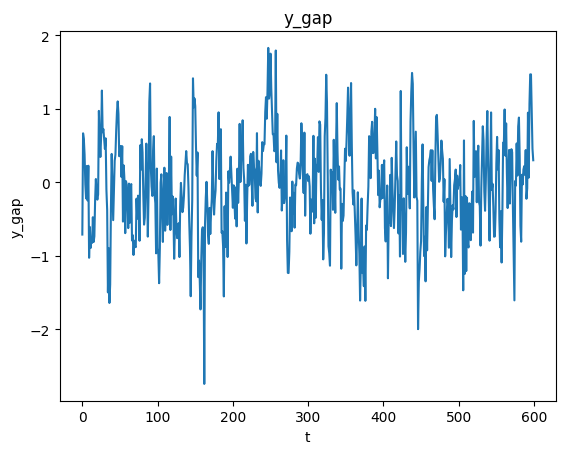

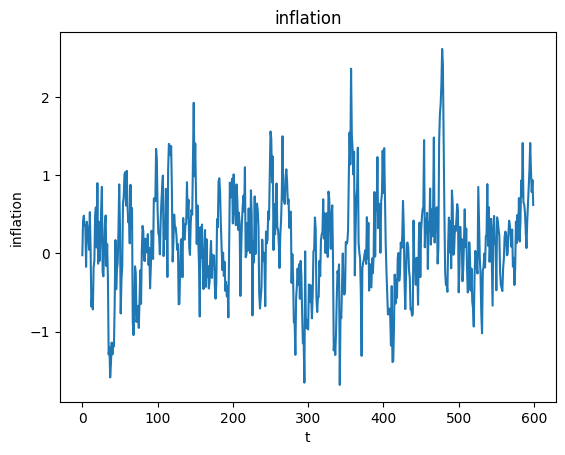

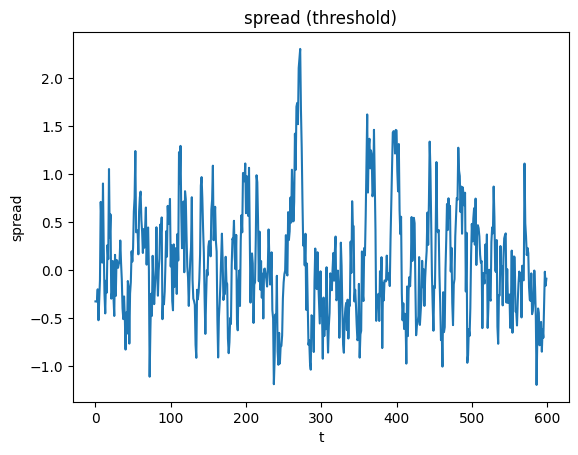

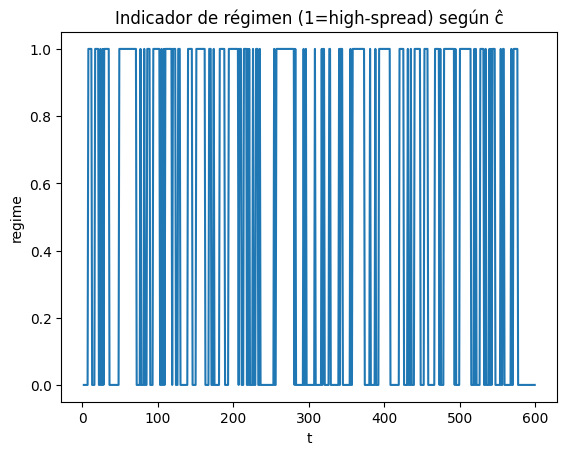

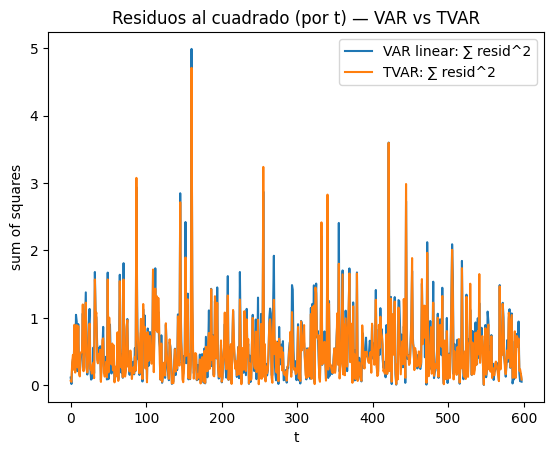

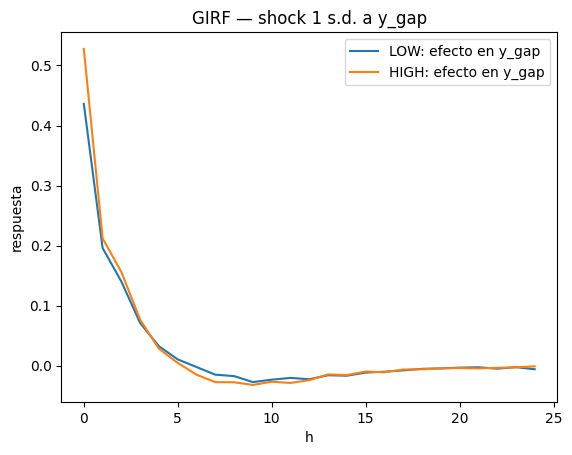

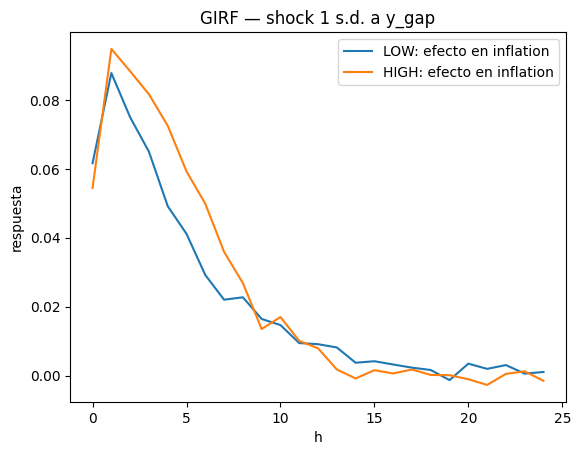

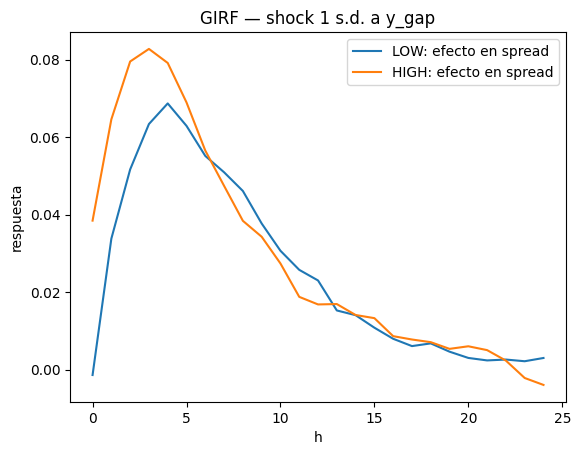

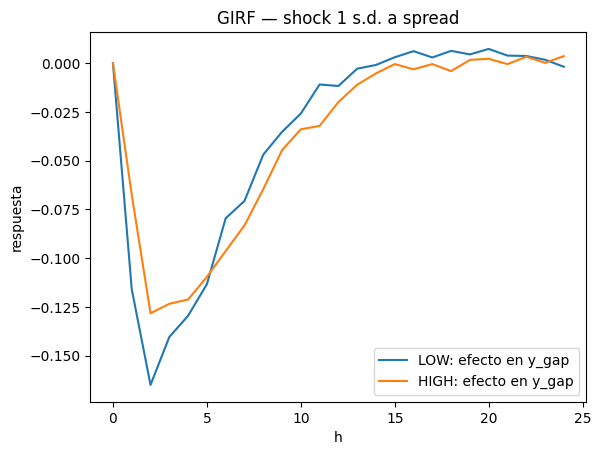

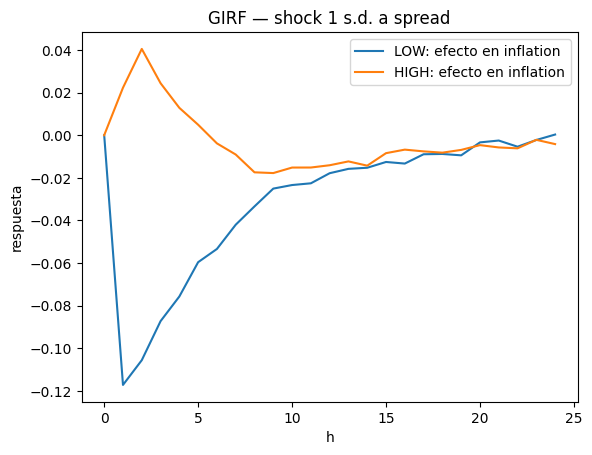

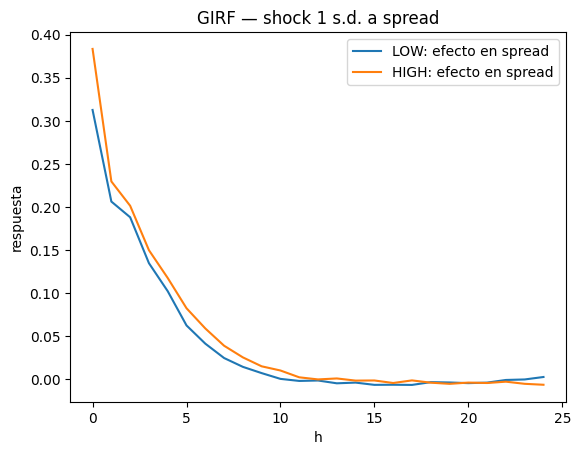

In [1]:
"""
Threshold VAR (TVAR) con datos macro sintéticos — de inicio a fin.
------------------------------------------------------------------
Qué hace:
1) Simula una economía de 3 variables: (y_gap, inflacion, spread).
2) Estima VAR(p) lineal (p por BIC) y TVAR (2 regímenes) con umbral en spread_{t-d}.
3) Test bootstrap: mejora en SSE del TVAR vs VAR lineal (resampling vectorial).
4) Estabilidad por régimen (eigenvalores del compañero).
5) GIRFs (Koop–Pesaran–Potter) con identificación Cholesky por régimen.
6) Tablas y gráficos clave.

Dependencias: numpy, pandas, matplotlib
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv, lstsq, cholesky, eigvals

# =========================
# Utilidades de construcción
# =========================
def lagmat(Y, p):
    """
    Construye la matriz de regresores para VAR(p).
    Devuelve X (n x (1+k*p)) con intercepto y Ytrim (n x k) alineada, n = T-p.
    """
    T, k = Y.shape
    if T <= p:
        raise ValueError("T debe ser > p.")
    X = []
    for t in range(p, T):
        row = [1.0]
        for i in range(1, p+1):
            row.extend(Y[t-i, :])
        X.append(row)
    return np.asarray(X), Y[p:, :]

def select_var_lag(Y, pmax=6):
    """
    Selecciona p por BIC (y reporta AIC/BIC) para un VAR lineal.
    Retorna p_star y una tabla con criterios.
    """
    T, k = Y.shape
    results = []
    for p in range(1, pmax+1):
        X, Ytrim = lagmat(Y, p)
        B = lstsq(X, Ytrim, rcond=None)[0]   # (1+k*p) x k
        resid = Ytrim - X @ B                # (n x k)
        sse = float(np.sum(resid**2))
        n = len(Ytrim)
        k_params = B.size
        # Supuesto Gauss: log-like ~ -n*k/2 * log(sigma^2)
        sigma2 = sse / (n * k)
        bic = n * k * np.log(sigma2) + np.log(n) * k_params
        aic = n * k * np.log(sigma2) + 2 * k_params
        results.append((p, sse, aic, bic))
    df = pd.DataFrame(results, columns=["p","SSE","AIC","BIC"])
    p_star = int(df.loc[df["BIC"].idxmin(),"p"])
    return p_star, df

def companion_max_eig(B, k, p):
    """
    Máximo módulo de eigenvalor del compañero (estabilidad) para un VAR dado.
    B: (1+k*p) x k apilado (intercepto + bloques Ai transpuestos).
    """
    A = np.zeros((k*p, k*p))
    for i in range(p):
        Ai = B[1 + i*k : 1 + (i+1)*k, :].T  # k x k
        A[:k, i*k:(i+1)*k] = Ai
    if p > 1:
        A[k:, :-k] = np.eye(k*(p-1))
    return float(np.max(np.abs(eigvals(A))))

def aic_bic_from_resid(resid, n_params):
    """
    Métricas AIC/BIC a partir de residuales Ytrim - X@B (n x k).
    """
    n, k = resid.shape
    sse = float(np.sum(resid**2))
    sigma2 = sse / (n * k)
    aic = n * k * np.log(sigma2) + 2 * n_params
    bic = n * k * np.log(sigma2) + np.log(n) * n_params
    return sse, sigma2, aic, bic

# =========================
# 1) Simulación macro sintética con umbral
# =========================
def simulate_macro_tvar(T=600, p_true=2, c_true=0.0, delay_d=1, seed=2025):
    """
    Simula 3 variables: y_gap, inflación, spread.
    Dos regímenes (umbral en spread_{t-d}).
    """
    rng = np.random.default_rng(seed)
    k = 3

    # Matrices por régimen B_s: (1+k*p_true) x k = intercepto + bloques A1..Ap transpuestos
    B1 = np.zeros((1 + k*p_true, k))  # régimen "benigno": persistencia mayor
    B2 = np.zeros((1 + k*p_true, k))  # régimen "tenso" (spread alto): persistencia menor

    # Interceptos
    B1[0,:] = [0.05, 0.02, 0.00]
    B2[0,:] = [-0.05, -0.02, 0.00]

    # A1 y A2 (k x k) por régimen (antes de transponer para apilar en B)
    A1_reg1 = np.array([[0.55, 0.05, -0.05],
                        [0.10, 0.60,  0.00],
                        [0.05, 0.05,  0.50]])
    A2_reg1 = np.array([[0.15, 0.00, -0.02],
                        [0.00, 0.25,  0.00],
                        [0.00, 0.05,  0.20]])

    A1_reg2 = np.array([[0.35, 0.05, -0.15],
                        [0.05, 0.40,  0.10],
                        [0.05, 0.10,  0.55]])
    A2_reg2 = np.array([[0.05, 0.00, -0.05],
                        [0.00, 0.15,  0.05],
                        [0.00, 0.05,  0.25]])

    # Apilar en B1/B2 (transponiendo cada bloque Ai)
    B1[1:1+k,:]        = A1_reg1.T
    B1[1+k:1+2*k,:]    = A2_reg1.T
    B2[1:1+k,:]        = A1_reg2.T
    B2[1+k:1+2*k,:]    = A2_reg2.T

    # Covarianzas por régimen
    Sigma1 = np.array([[0.20, 0.03, 0.00],
                       [0.03, 0.15, 0.02],
                       [0.00, 0.02, 0.10]])
    Sigma2 = np.array([[0.30, 0.05, 0.02],
                       [0.05, 0.25, 0.04],
                       [0.02, 0.04, 0.15]])

    # Simular (warmup + muestra)
    Y = np.zeros((T + 200, k))
    for t in range(p_true, T+200):
        z = Y[t - delay_d, 2]  # spread en t-d
        regime2 = (z > c_true)
        B = B2 if regime2 else B1
        Sigma = Sigma2 if regime2 else Sigma1
        e_t = rng.multivariate_normal(np.zeros(k), Sigma)
        x = [1.0]
        for i in range(1, p_true+1):
            x.extend(Y[t-i, :])
        Y[t,:] = np.asarray(x) @ B + e_t

    Y = Y[-T:, :]
    return Y, ["y_gap","inflation","spread"]

# =========================
# 2) TVAR (estimación por grid en c) y test bootstrap
# =========================
def fit_tvar(Y, p, z_series, d=1, q_low=0.15, q_high=0.85, ngrid=61, min_frac=0.15):
    """
    Estima un TVAR de 2 regímenes con umbral c en z_{t-d}.
    - Busca c en cuantiles [q_low, q_high], exige fracción mínima min_frac por régimen.
    - OLS por régimen (todas las ecuaciones a la vez).
    Devuelve dict con c, B1,B2,Sigma1,Sigma2,resid, máscaras I1/I2, etc.
    """
    T, k = Y.shape
    if not (1 <= d < T):
        raise ValueError("El delay d debe ser >=1 y < T.")
    X, Ytrim = lagmat(Y, p)        # Ytrim corresponde a t = p..T-1 (n=T-p filas)
    n = len(Ytrim)
    # Alinear z_{t-d} con Ytrim: t=p..T-1  ->  índice de z va de (p-d) .. (T-1-d)
    z = z_series[p - d : T - d]
    if len(z) != n:
        raise RuntimeError("Alineación de z y Ytrim inconsistente. Revisa p y d.")
    qgrid = np.linspace(q_low, q_high, ngrid)
    cands = np.quantile(z, qgrid)
    min_obs = int(min_frac * n)

    best = None
    for c in cands:
        I2 = (z > c)              # régimen alto (z>c)
        I1 = ~I2                  # régimen bajo (z<=c)
        if I1.sum() < min_obs or I2.sum() < min_obs:
            continue
        B1 = lstsq(X[I1,:], Ytrim[I1,:], rcond=None)[0]
        B2 = lstsq(X[I2,:], Ytrim[I2,:], rcond=None)[0]
        resid = np.empty_like(Ytrim)
        resid[I1,:] = Ytrim[I1,:] - X[I1,:] @ B1
        resid[I2,:] = Ytrim[I2,:] - X[I2,:] @ B2
        sse = float(np.sum(resid**2))
        if (best is None) or (sse < best["sse"]):
            Sigma1 = (resid[I1,:].T @ resid[I1,:]) / I1.sum()
            Sigma2 = (resid[I2,:].T @ resid[I2,:]) / I2.sum()
            best = dict(c=c, B1=B1, B2=B2, Sigma1=Sigma1, Sigma2=Sigma2,
                        resid=resid, I1=I1, I2=I2, z=z, X=X, Ytrim=Ytrim, sse=sse)
    return best

def bootstrap_test_linear_vs_tvar(Y, p, B_lin, z_series, d=1, B=150, seed=1):
    """
    Test bootstrap de no linealidad: Δ = SSE_VAR - SSE_TVAR.
    - Re-muestrea residuales vectoriales del VAR lineal (preserva correlación cruzada).
    - Re-estima VAR y TVAR en cada réplica y computa Δ_b.
    p-valor ≈ Pr(Δ_b >= Δ_obs).
    """
    rng = np.random.default_rng(seed)
    X, Ytrim = lagmat(Y, p)
    U = Ytrim - X @ B_lin
    sse_lin_obs = float(np.sum(U**2))
    tvar_obs = fit_tvar(Y, p, z_series, d=d)
    sse_tvar_obs = tvar_obs["sse"]
    delta_obs = sse_lin_obs - sse_tvar_obs

    T, k = Y.shape
    deltas = np.empty(B)
    for b in range(B):
        draw_idx = rng.integers(0, U.shape[0], size=U.shape[0])
        U_star = U[draw_idx, :]  # residuales vectoriales con reemplazo
        # Generar serie bootstrap bajo el modelo lineal
        Y_star = np.zeros_like(Y)
        Y_star[:p, :] = Y[:p, :]  # condiciones iniciales
        for t in range(p, T):
            x = [1.0]
            for i in range(1, p+1):
                x.extend(Y_star[t-i, :])
            Y_star[t, :] = np.asarray(x) @ B_lin + U_star[t-p, :]
        # Re-estimar
        Xs, Ys = lagmat(Y_star, p)
        B_lin_b = lstsq(Xs, Ys, rcond=None)[0]
        sse_lin_b = float(np.sum((Ys - Xs @ B_lin_b)**2))
        tvar_b = fit_tvar(Y_star, p, z_series=Y_star[:, -1], d=d)  # umbral en la última col (spread)
        deltas[b] = sse_lin_b - tvar_b["sse"]

    pval = (np.sum(deltas >= delta_obs) + 1) / (B + 1)
    return delta_obs, deltas, pval

# =========================
# 3) GIRFs (Koop–Pesaran–Potter) con identificación por régimen
# =========================
def simulate_tvar_path(B1, B2, c, p, Y0, shocks_seq, Sigma1, Sigma2, d=1, seed=10, spread_col=-1):
    """
    Simula una trayectoria del TVAR aplicando shocks reducidos (u_t) determinísticos (shocks_seq).
    - shocks_seq: (H x k) con u_t añadidos a las innovaciones en cada paso.
    - Y0: bloque inicial (p x k).
    """
    rng = np.random.default_rng(seed)
    H, k = shocks_seq.shape
    Y_sim = np.zeros((H + p, k))
    Y_sim[:p, :] = Y0[-p:, :]
    for t in range(p, H + p):
        z = Y_sim[t - d, spread_col]
        B = B2 if (z > c) else B1
        Sigma = Sigma2 if (z > c) else Sigma1
        e = rng.multivariate_normal(np.zeros(k), Sigma) + shocks_seq[t-p, :]
        x = [1.0]
        for i in range(1, p+1):
            x.extend(Y_sim[t-i, :])
        Y_sim[t, :] = np.asarray(x) @ B + e
    return Y_sim

def tvar_girf(B1, B2, c, p, Sigma1, Sigma2, init_state, shock_var, horizon=20, R=300,
              shock_size=1.0, spread_col=-1, seed=99):
    """
    GIRF (Koop-Pesaran-Potter):
    GIRF(h) = E[y_{t+h} | shock_j, S0] - E[y_{t+h} | no shock, S0],
    con identificación Cholesky por régimen (P_s P_s' = Sigma_s), shock estructural en j.
    """
    k = Sigma1.shape[0]
    P1 = cholesky(Sigma1)
    P2 = cholesky(Sigma2)
    # Elegir P según el estado inicial (regla simple; ambas opciones son posibles)
    z0 = init_state[-1, spread_col]
    P_use = P2 if (z0 > c) else P1

    e0 = np.zeros(k); e0[shock_var] = shock_size      # shock estructural unitario
    u0 = P_use @ e0                                   # shock reducido equivalente

    diffs = np.zeros((horizon+1, k))
    for r in range(R):
        shocks_shock = np.zeros((horizon+1, k)); shocks_shock[0, :] = u0
        shocks_base  = np.zeros((horizon+1, k))
        Y_shock = simulate_tvar_path(B1, B2, c, p, init_state, shocks_shock, Sigma1, Sigma2,
                                     d=1, seed=seed+r, spread_col=spread_col)
        Y_base  = simulate_tvar_path(B1, B2, c, p, init_state, shocks_base,  Sigma1, Sigma2,
                                     d=1, seed=seed+r, spread_col=spread_col)
        diffs += (Y_shock[p:p+horizon+1, :] - Y_base[p:p+horizon+1, :])
    return diffs / R

# =========================
# 4) Empaques y visualización
# =========================
def unpack_B(B, k, p):
    """
    Devuelve dict con 'intercept' y bloques A1..Ap (cada Ai como k x k).
    """
    out = {"intercept": B[0, :]}
    for i in range(p):
        out[f"A{i+1}"] = B[1 + i*k : 1 + (i+1)*k, :].T
    return out

def pretty_print_coeffs(B, varnames, title):
    """
    Imprime intercepto y bloques Ai con etiquetas de variables.
    """
    k = len(varnames)
    p = (B.shape[0] - 1) // k
    Bu = unpack_B(B, k, p)
    print(f"\n=== {title} ===")
    print("Intercepto:", dict(zip(varnames, Bu["intercept"])))
    for i in range(1, p+1):
        A = Bu[f"A{i}"]
        dfA = pd.DataFrame(A, index=[f"{v}(t-1)" for v in varnames], columns=[f"eq_{v}" for v in varnames])
        print(f"\nBloque A{i}:")
        print(dfA.round(3))

# =========================
# 5) MAIN — correr todo
# =========================
if __name__ == "__main__":
    # --- (A) Datos: simular o reemplazar por los tuyos ---
    Y, cols = simulate_macro_tvar(T=600, p_true=2, c_true=0.0, delay_d=1, seed=2025)
    # Si usas tus datos:
    # import your_data_loading as dl
    # df = dl.load(...)
    # Y = df[["y_gap","inflation","spread"]].dropna().to_numpy(float)
    # cols = ["y_gap","inflation","spread"]

    k = Y.shape[1]
    spread_col = cols.index("spread")

    # --- (B) VAR lineal: selección de rezagos y estimación ---
    p_star, crit = select_var_lag(Y, pmax=6)
    print("\nSelección de rezagos (BIC):\n", crit.assign(chosen=(crit["p"]==p_star)).to_string(index=False))

    X_lin, Y_lin = lagmat(Y, p_star)
    B_lin = lstsq(X_lin, Y_lin, rcond=None)[0]
    U_lin = Y_lin - X_lin @ B_lin
    Sigma_lin = (U_lin.T @ U_lin) / U_lin.shape[0]
    sse_lin, s2_lin, aic_lin, bic_lin = aic_bic_from_resid(U_lin, n_params=B_lin.size)
    print(f"\nVAR lineal (p={p_star}) — SSE={sse_lin:.3f}, sigma2={s2_lin:.4f}, AIC={aic_lin:.2f}, BIC={bic_lin:.2f}")

    # --- (C) TVAR: estimación (umbral en spread_{t-1}, d=1) ---
    z_series = Y[:, spread_col]
    tvar = fit_tvar(Y, p_star, z_series, d=1, q_low=0.15, q_high=0.85, ngrid=61, min_frac=0.15)
    print(f"\nTVAR — umbral estimado c ≈ {tvar['c']:.3f}")
    sse_tvar, s2_tvar, aic_tvar, bic_tvar = aic_bic_from_resid(tvar["resid"], n_params=tvar["B1"].size + tvar["B2"].size + 1)
    print(f"TVAR — SSE={sse_tvar:.3f}, sigma2={s2_tvar:.4f}, AIC={aic_tvar:.2f}, BIC={bic_tvar:.2f}")

    # Coeficientes por régimen
    pretty_print_coeffs(tvar["B1"], cols, "TVAR — Régimen LOW (z<=c)")
    pretty_print_coeffs(tvar["B2"], cols, "TVAR — Régimen HIGH (z>c)")

    # Estabilidad por régimen
    stab1 = companion_max_eig(tvar["B1"], k, p_star)
    stab2 = companion_max_eig(tvar["B2"], k, p_star)
    print(f"\nEstabilidad (máx |eigenvalue|): Low={stab1:.3f}, High={stab2:.3f}")

    # --- (D) Test bootstrap: VAR vs TVAR ---
    delta_obs, deltas, pval = bootstrap_test_linear_vs_tvar(Y, p_star, B_lin, z_series, d=1, B=120, seed=7)
    print(f"\nBootstrap test (Δ=SSE_VAR - SSE_TVAR): Δ_obs={delta_obs:.3f}, p-valor≈{pval:.3f}, B={len(deltas)}")

    # --- (E) GIRFs por régimen (Cholesky por régimen) ---
    # Construir estados iniciales representativos de cada régimen
    I2_hat = tvar["I2"]              # True si z>c en cada fila (alineado con Ytrim)
    I1_hat = ~I2_hat
    def get_init_state(Y, p, mask):
        idx = np.where(mask)[0]
        if len(idx) == 0:
            idx = np.arange(len(Y)-p)  # fallback
        t0 = idx[-1] + p
        return Y[t0-p:t0, :]

    init_low  = get_init_state(Y, p_star, I1_hat)
    init_high = get_init_state(Y, p_star, I2_hat)

    H, R = 24, 250
    girf_low_gap  = tvar_girf(tvar["B1"], tvar["B2"], tvar["c"], p_star, tvar["Sigma1"], tvar["Sigma2"],
                              init_low, shock_var=0, horizon=H, R=R, shock_size=1.0, spread_col=spread_col)
    girf_high_gap = tvar_girf(tvar["B1"], tvar["B2"], tvar["c"], p_star, tvar["Sigma1"], tvar["Sigma2"],
                              init_high, shock_var=0, horizon=H, R=R, shock_size=1.0, spread_col=spread_col)
    girf_low_spr  = tvar_girf(tvar["B1"], tvar["B2"], tvar["c"], p_star, tvar["Sigma1"], tvar["Sigma2"],
                              init_low, shock_var=spread_col, horizon=H, R=R, shock_size=1.0, spread_col=spread_col)
    girf_high_spr = tvar_girf(tvar["B1"], tvar["B2"], tvar["c"], p_star, tvar["Sigma1"], tvar["Sigma2"],
                              init_high, shock_var=spread_col, horizon=H, R=R, shock_size=1.0, spread_col=spread_col)

    # --- (F) Gráficos básicos ---
    t = np.arange(len(Y))
    plt.figure(); plt.plot(t, Y[:,0]); plt.title("y_gap"); plt.xlabel("t"); plt.ylabel("y_gap"); plt.show()
    plt.figure(); plt.plot(t, Y[:,1]); plt.title("inflation"); plt.xlabel("t"); plt.ylabel("inflation"); plt.show()
    plt.figure(); plt.plot(t, Y[:,2]); plt.title("spread (threshold)"); plt.xlabel("t"); plt.ylabel("spread"); plt.show()

    # Indicador de régimen en tiempo (para t>=p)
    plt.figure()
    plt.plot(np.arange(p_star, len(Y)), I2_hat.astype(int))
    plt.title("Indicador de régimen (1=high-spread) según ĉ"); plt.xlabel("t"); plt.ylabel("regime")
    plt.show()

    # Residuos al cuadrado (punto a punto): VAR vs TVAR
    res_lin = (Y_lin - X_lin @ B_lin)**2
    res_tvar = tvar["resid"]**2
    plt.figure()
    plt.plot(np.sum(res_lin, axis=1), label="VAR linear: ∑ resid^2")
    plt.plot(np.sum(res_tvar, axis=1), label="TVAR: ∑ resid^2")
    plt.title("Residuos al cuadrado (por t) — VAR vs TVAR")
    plt.xlabel("t"); plt.ylabel("sum of squares"); plt.legend(); plt.show()

    # GIRFs: shock a y_gap
    hgrid = np.arange(H+1)
    for j,name in enumerate(cols):
        plt.figure()
        plt.plot(hgrid, girf_low_gap[:,j],  label=f"LOW: efecto en {name}")
        plt.plot(hgrid, girf_high_gap[:,j], label=f"HIGH: efecto en {name}")
        plt.title("GIRF — shock 1 s.d. a y_gap"); plt.xlabel("h"); plt.ylabel("respuesta"); plt.legend(); plt.show()

    # GIRFs: shock a spread
    for j,name in enumerate(cols):
        plt.figure()
        plt.plot(hgrid, girf_low_spr[:,j],  label=f"LOW: efecto en {name}")
        plt.plot(hgrid, girf_high_spr[:,j], label=f"HIGH: efecto en {name}")
        plt.title("GIRF — shock 1 s.d. a spread"); plt.xlabel("h"); plt.ylabel("respuesta"); plt.legend(); plt.show()


In [3]:
Y.shape

(600, 3)